# **COMPUTER VISION TECHNIQUES - part 3**
## By: Ayush Adarsh
### Notebook no. : 5


## **Image Segmentation**
* Image segmentation is a fundamental task in computer vision that involves partitioning an image into multiple regions or segments, typically based on characteristics like color, intensity, texture, or other features.

* The goal of image segmentation is to simplify or change the representation of an image into something that is more meaningful and easier to analyze.

* Each segment represents a different part of the image that may correspond to an object, region, or boundary.

## **Uses**
* **Object Localization:** Image segmentation helps isolate specific objects from the background, allowing for more accurate detection of items in an image (e.g., people, cars, animals).

* **Instance Segmentation:** Going beyond just detecting objects, instance segmentation also differentiates between different instances of the same object (e.g., distinguishing between two different cars in the same image).

* **Contextual Understanding:** Helps in understanding the context or environment by segmenting the image into meaningful regions. For example, segmenting a street scene into roads, sidewalks, buildings, and pedestrians helps an autonomous vehicle understand the environment.

Region Growing, Edge Based approaches to segmentation, Graph-Cut, Mean-Shift, MRFs, Texture Segmentation;

## **1. Region Growing**

### 1. Intuition
* The idea is to start with a set of initial seed points and grow regions by adding neighboring pixels that have similar properties (such as intensity, color, or texture).

* The process stops when the similarity criterion is not met or when the entire image is segmented.

* This method is intuitive as it mimics how humans might manually group pixels into meaningful regions by assessing similarity.


### 2. Mathematical Formulation

#### Seed Initialization:
Select one or more seed points $S = \{s_1, s_2, \ldots, s_k\}$, where $s_i = (x_i, y_i)$ are pixel coordinates.

---

#### Similarity Criterion:
Define a function $\phi(p, q)$ to evaluate similarity between pixels $p$ and $q$:

$$
\phi(p, q) =
\begin{cases}
1 & \text{if } |I(p) - I(q)| \leq T \\
0 & \text{otherwise}
\end{cases}
$$

Here, $I(p)$ represents the intensity (or other property) of pixel $p$, and $T$ is the similarity threshold.

---

#### Region Growing:
Grow the region $R$ iteratively:

$$
R_{t+1} = R_t \cup \{p \in \text{Neighbors}(R_t) \mid \phi(p, s) = 1 \text{ for any } s \in R_t\}
$$

---

#### Stopping Criterion:
Stop when there are no new pixels to add:

$$
R_{t+1} = R_t
$$


In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

image = cv2.imread('Cat.jpg', cv2.IMREAD_GRAYSCALE)

In [19]:
def region_growing(image, seed_point, threshold):
    rows, cols = image.shape
    segmented = np.zeros_like(image, dtype=np.uint8)  # Output segmented image
    visited = np.zeros_like(image, dtype=bool)  # Visited pixels

    seed_x, seed_y = seed_point
    seed_value = image[seed_x, seed_y]

    stack = [(seed_x, seed_y)]  # Stack to hold pixels to process

    while stack:
        x, y = stack.pop()
        if not visited[x, y]:
            visited[x, y] = True
            diff = abs(int(image[x, y]) - int(seed_value))

            if diff <= threshold:
                segmented[x, y] = 255  # Mark as part of the region(color segmented region as black , here we have made it 255 pixels(black)
                # Add neighbors
                for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                    nx, ny = x + dx, y + dy
                    if 0 <= nx < rows and 0 <= ny < cols and not visited[nx, ny]:
                        stack.append((nx, ny))
    return segmented

In [20]:
# Parameters
seed = (10, 10)  #seed point
threshold1 = 100   #intensity threshold (check output at different thresholds)
threshold2 = 200
threshold3 = 50
output1 = region_growing(image, seed, threshold1)
output2 = region_growing(image, seed, threshold2)
output3 = region_growing(image, seed, threshold3)

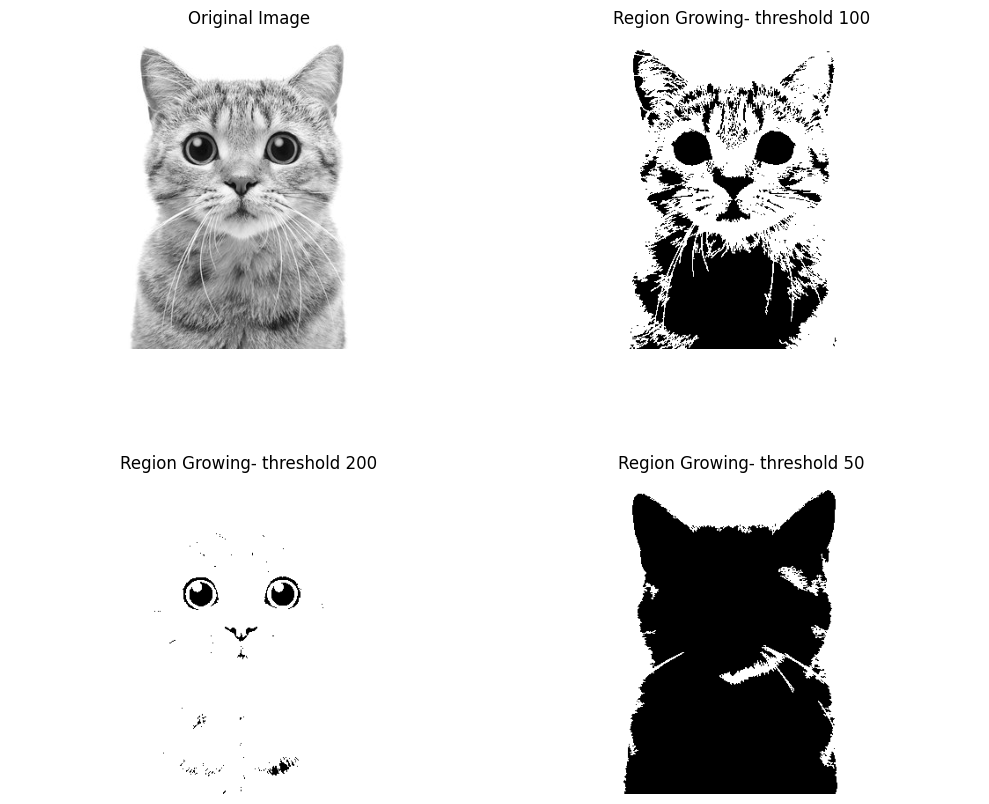

In [25]:
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.title("Original Image")
plt.imshow(image, cmap='gray')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.title("Region Growing- threshold 100")
plt.imshow(output1, cmap='gray')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.title("Region Growing- threshold 200")
plt.imshow(output2, cmap='gray')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.title("Region Growing- threshold 50")
plt.imshow(output3, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()


## **2. Graph-Cut Segmentation**

### Intuition
* Graph-Cut is an optimization-based image segmentation technique used to partition an image into multiple regions.

* The image is represented as a graph where each pixel is a node, and the edges between nodes represent the similarity or dissimilarity between neighboring pixels.

* The goal is to minimize a cost function that encourages pixels in the same region to be similar and encourages neighboring regions to be distinct.

* This is done by cutting the graph into disjoint sets that minimize an energy function, typically represented as a graph cut.

* The image segmentation problem is transformed into a graph partitioning problem, where the minimum cut between nodes is sought to achieve optimal segmentation.

### Mathematical Formulation

#### Graph Representation:
Represent an image as a graph $G = (V, E)$, where:

- $V$ is the set of pixels (nodes),
- $E$ is the set of edges connecting adjacent pixels.

---

#### Energy Function:
The energy function consists of two terms:

- **Data term ($D$):** Measures the likelihood of a pixel belonging to a foreground or background.
- **Smoothness term ($S$):** Measures the similarity between neighboring pixels.

The energy function to minimize is:

$$
E(f) = \sum_{i \in V} D_i(f_i) + \sum_{(i, j) \in E} S_{ij}(f_i, f_j)
$$

Where:

- $f_i$ is the label of pixel $i$ (foreground or background),
- $D_i(f_i)$ is the data term, representing the cost of assigning a label to pixel $i$,
- $S_{ij}(f_i, f_j)$ is the smoothness term, which penalizes labeling adjacent pixels differently.
- each pixel is assigned a label of either **foreground** (the object of interest) or **background** (the surrounding area) based on its similarity to neighboring pixels.
- For example, in a photo of a person in a park, the foreground would represent the person, and the background would represent the park and sky. The goal is to partition the image into these regions using energy minimization techniques like the Min-Cut algorithm.

---

#### Min-Cut Problem:
The goal is to partition the graph into two sets, one representing the foreground and the other representing the background, such that the cut that separates the two sets minimizes the energy function. The solution to the minimum cut problem provides the optimal segmentation:

$$
\text{Minimize } E(f) = \text{Min-Cut}(G)
$$


In [27]:
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [28]:
# Create a mask, where we specify the foreground and background
mask = np.zeros(image.shape[:2], np.uint8)

# Define the background and foreground models
bgd_model = np.zeros((1, 65), np.float64)
fgd_model = np.zeros((1, 65), np.float64)

# Define rectangle for the region of interest (ROI) to segment
rect = (50, 50, image.shape[1]-50, image.shape[0]-50)

# Apply GrabCut algorithm (Graph-Cut method)
cv2.grabCut(image, mask, rect, bgd_model, fgd_model, 5, cv2.GC_INIT_WITH_RECT)

# Modify mask to create a binary mask
mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')

# Segment the image
result = image_rgb * mask2[:, :, np.newaxis]


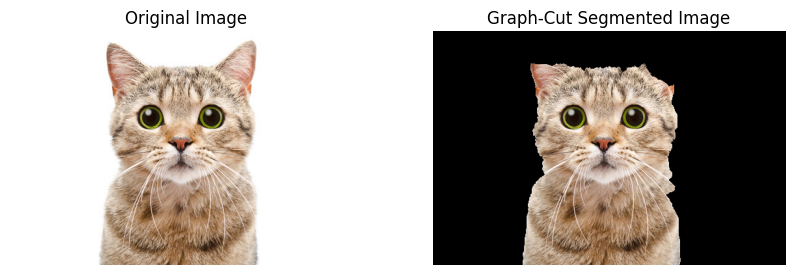

In [29]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image_rgb)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Graph-Cut Segmented Image")
plt.imshow(result)
plt.axis('off')

plt.show()

## **3. Mean Shift Method**

### Intuition
- A non-parametric clustering algorithm used for image segmentation and object tracking.
- The core idea is to iteratively shift a kernel window towards the region of maximum density in the feature space, which helps in finding modes (dense regions) of the data.
- Mean-Shift algorithm works by shifting each pixel's value to the average of its neighbors in a defined feature space, which can be color or spatial coordinates.
- As the window moves, it converges to the mode, representing a distinct region in the image.

### Mathematical Formulation

#### Feature Space:
The feature space for Mean-Shift is typically defined by the spatial location of pixels (in terms of coordinates $(x, y)$) and the intensity/color values (e.g., RGB or HSV).

---

#### Kernel Function:
Mean-Shift uses a kernel function (typically a Gaussian kernel) to weigh the neighboring points. The kernel defines the influence of nearby points on the mean shift.

The kernel function is given by:

$$
K(z) = \frac{1}{(2\pi h^2)^{d/2}} \exp\left( -\frac{|z|^2}{2h^2} \right)
$$

Where:

- $h$ is the bandwidth parameter controlling the size of the kernel,
- $d$ is the dimensionality of the feature space.

---

#### Mean-Shift Vector:
For each pixel, the Mean-Shift vector is calculated as the weighted average of its neighbors, moving the pixel towards the region of higher density. This is given by:

$$
m(x) = \frac{\sum_{x_i \in N(x)} K(x_i - x) \cdot x_i}{\sum_{x_i \in N(x)} K(x_i - x)}
$$

Where:

- $x$ is the current point (pixel),
- $x_i$ are the neighboring points,
- $K$ is the kernel.
- $N(x)$ is the set of neighbourhood points

---

#### Iterative Process:
The Mean-Shift algorithm iteratively shifts each point towards the mode (dense region) of its neighborhood until convergence, which is when the shift is small enough.


In [30]:
image = cv2.imread('Cat.jpg')
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [35]:
# Apply Mean-Shift segmentation using OpenCV's built-in function
# The parameters are:
# - image: The input image.
# - sp: spatial radius (affects the segmentation)
# - sr: color radius (affects color grouping)
# - maxLevel: maximum level for pyramid (speed-up factor)

mean_shift_result = cv2.pyrMeanShiftFiltering(image, sp=21, sr=51, maxLevel=3)

# Convert the result to RGB for display
mean_shift_rgb = cv2.cvtColor(mean_shift_result, cv2.COLOR_BGR2RGB)


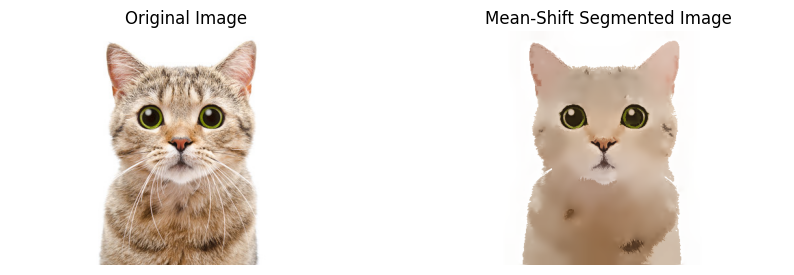

In [36]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image_rgb)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Mean-Shift Segmented Image")
plt.imshow(mean_shift_rgb)
plt.axis('off')

plt.show()


## **4. Markov Random Fields**

### Intuition
- Probabilistic model
- MRFs model spatial dependencies between pixels (or image regions) by representing them as a set of random variables, where the value of a pixel depends on the values of its neighboring pixels.
- The key property of MRFs is the Markov property, where the state of a pixel (node) depends only on the states of its neighbors (adjacent nodes), not on the entire image.
- This local dependence structure makes MRFs suitable for segmentation tasks, where classify regions based on their similarity with neighboring pixels.

- The energy function, which is minimized during segmentation, typically consists of two parts:
      -- Data term: This measures how well the pixels match the observed data (color, intensity, etc.).

      -- Smoothness term: This encourages neighboring pixels to have similar labels(foreground and background), enforcing spatial coherence(i.e. nearby points have similiar or related properties) in the segmentation.


### Mathematical Formulation

In a Markov Random Field (MRF), the image is represented as a graph, where each pixel or region is a node, and edges represent the dependencies between neighboring pixels. The goal is to estimate the label field $ L = \{l_1, l_2, \dots, l_N\} $ for all the nodes (pixels) in the graph.

### Energy Function

The energy function for the MRF is given by:

$$
E(L) = \sum_{i} \Psi_{\text{data}}(l_i, I_i) + \sum_{(i,j) \in \mathcal{N}} \Psi_{\text{smooth}}(l_i, l_j)
$$

Where:

- $ \Psi_{\text{data}}(l_i, I_i) $: The data term measures the compatibility of the label $ l_i $ of pixel $ i $ with the observed data $ I_i $ (such as pixel intensity or color).
- $ \Psi_{\text{smooth}}(l_i, l_j) $: The smoothness term measures the compatibility of labels between neighboring pixels. It ensures that neighboring pixels are more likely to have the same label.
- $ (i, j) \in \mathcal{N} $: Indicates neighboring pixels.
- $ l_i $ and $ l_j $ are the labels of the neighboring pixels $ i $ and $ j $.

### Data Term

The data term measures the likelihood of a pixel belonging to a certain class based on the image intensity. It can be formulated as:

$$
\Psi_{\text{data}}(l_i, I_i) = -\log P(I_i | l_i)
$$

Where $ P(I_i | l_i) $ is the probability of pixel $ i $'s intensity $ I_i $ given the label $ l_i $.

### Smoothness Term

The smoothness term enforces spatial coherence by penalizing label changes between neighboring pixels:

$$
\Psi_{\text{smooth}}(l_i, l_j) = \lambda \cdot \delta(l_i, l_j)
$$

Where $ \delta(l_i, l_j) $ is a function that is typically 0 when $ l_i = l_j $ (meaning the labels are the same) and 1 when $ l_i \neq l_j $ (meaning the labels are different). $ \lambda $ is a regularization parameter that controls the weight of the smoothness term.

### Energy Minimization

The objective is to find the label configuration $ L $ that minimizes the energy function $ E(L) $:

$$
L^* = \arg \min_{L} E(L)
$$

This minimization can be done using algorithms like Graph Cuts, Belief Propagation, or Iterated Conditional Modes (ICM).


In [39]:
from skimage.segmentation import slic
from skimage.color import label2rgb

In [59]:
def markov_random_field_segmentation(image, num_segments=2, compactness=10):
    """
    Perform image segmentation using Markov Random Field approach with SLIC superpixels.

    Parameters:
    - image: Input image
    - num_segments: Number of segments to create
    - compactness: Compactness of superpixel segmentation

    Returns:
    - Segmented image
    """
    # Convert image to float and normalize
    image_float = image.astype(float) / 255.0

    # Apply SLIC superpixel segmentation
    segments = slic(image_float,
                    n_segments=num_segments,
                    compactness=compactness,
                    sigma=1)

    # Create color-coded segmentation overlay
    segmented_image = label2rgb(segments, image, kind='avg')  # you can use kind = 'avg' or kind = 'overlay'

    return segments, segmented_image


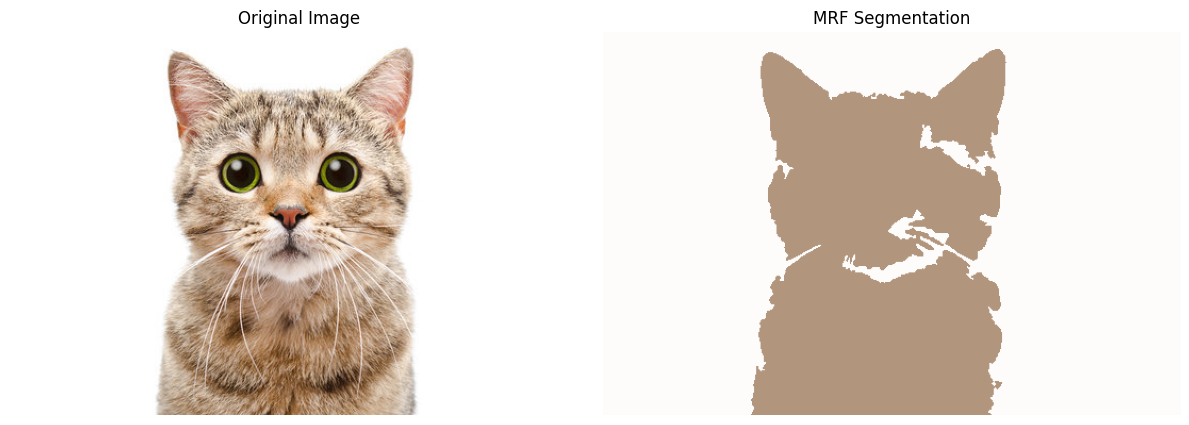

In [60]:
def main():
    # Read an example image (replace with your own image path)
    image = cv2.imread('Cat.jpg')

    # Convert from BGR to RGB (OpenCV uses BGR by default)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Perform Markov Random Field Segmentation
    segments, segmented_image = markov_random_field_segmentation(image_rgb)

    # Create a plot with original and segmented images
    plt.figure(figsize=(12, 5))

    # Original Image
    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(image_rgb)
    plt.axis('off')

    # Segmented Image
    plt.subplot(1, 2, 2)
    plt.title('MRF Segmentation')
    plt.imshow(segmented_image)
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Ensure the script can be run directly
if __name__ == '__main__':
    main()